In [1]:
!pip install global_land_mask

In [2]:
from global_land_mask import globe

### Extract the SSTA anomaly for each ENSO state

In [32]:
import pandas as pd
from netCDF4 import Dataset
import numpy as np
from scipy.io import savemat


def mean(state=None):
    global sst_0
    bool_index = (all_states == state) 

    ssta = sst_0[bool_index]
    sample_size = np.sum(bool_index)
    ssta_mean = np.mean(ssta, axis = 0)
    ssta_var = np.var(ssta, axis=0)

    ssta_mean_filled = np.where(ssta_mean.mask, np.nan, ssta_mean.data)
    ssta_var_filled = np.where(ssta_var.mask, np.nan, ssta_var.data)

    name = f"SSTA_MEAN_STATE_{state}.npy"
    np.save(name, ssta_mean_filled)
    name = f"SSTA_VAR_STATE_{state}.npy"
    np.save(name, ssta_var_filled)
    return ssta_mean_filled, ssta_var_filled, sample_size


df = pd.read_excel("Hidden_state_time_series_KAPLANSST.xlsx",
                   sheet_name="TIME SERIE", usecols="A:C", index_col="YEAR")

all_states = df.STATE.loc["1881":"2022"].array
all_months = df.MONTH.loc["1881":"2022"].array

nc_data = Dataset("sst.mon.anom.nc")  
sst_0 = nc_data["sst"][300:2004]  #1881.1-2022.12   
sample_sizes = {}


if __name__ == "__main__":
        for state in [1, 2, 3, 4, 5]:
            _, _, sample_size = mean(state=state)
            sample_sizes[state] = sample_size
            
print(sample_sizes)

{1: 234, 2: 139, 3: 599, 4: 339, 5: 393}


#### calculate the historical long-term mean

In [33]:
data = xr.open_dataset('sst.mon.anom.nc')

sst = data['sst'].sel(time=slice('1881-01-01', '2022-12-01'))
ltm = sst.mean(dim='time')

ltv = sst.var(dim='time')

ltm_np = ltm.values
ltv_np = ltv.values

np.save('ltm_1881_2022.npy', ltm_np)
np.save('ltv_1881_2022.npy', ltv_np)

data.close()

#### 显著性检验

In [4]:
from scipy.stats import ttest_ind_from_stats
import numpy as np

sample_sizes = {1: 234, 2: 139, 3: 599, 4: 339, 5: 393}

ltm = np.load('ltm_1881_2022.npy')
ltv = np.load('ltv_1881_2022.npy')
n_ltm = (2022 - 1881 + 1) * 12  

significant_maps = {}

for state in sample_sizes.keys():
    mean_state = np.load(f'SSTA_MEAN_STATE_{state}.npy')
    var_state = np.load(f'SSTA_VAR_STATE_{state}.npy')
    n_state = sample_sizes[state]

    std_state = np.sqrt(var_state)  
    std_ltm = np.sqrt(ltv)  

    t_stat, p_value = ttest_ind_from_stats(mean1=mean_state, std1=std_state, nobs1=n_state,
                                           mean2=ltm, std2=std_ltm, nobs2=n_ltm,
                                           equal_var=False)  

    significance_level = 0.05
    significant = p_value < significance_level

    significant_maps[state] = significant

### Extract the Wind anomaly for each ENSO state

In [3]:
#import os
import pandas as pd
from netCDF4 import Dataset
import numpy as np
from scipy.io import savemat
import xarray as xr


def mean(state=None):
    global uwind_0, vwind_0
    bool_index = (all_states == state) 

    uwinda = uwind_0[bool_index]
    uwinda_mean = np.mean(uwinda, axis=0)
    vwinda = vwind_0[bool_index]
    vwinda_mean = np.mean(vwinda, axis=0)
    
    name1 = f"UWNDA_MEAN_STATE_{state}.npy"
    name2 = f"VWNDA_MEAN_STATE_{state}.npy"
    np.save(name1, uwinda_mean)
    np.save(name2, vwinda_mean)
    return uwinda_mean, vwinda_mean


df = pd.read_excel("Hidden_state_time_series_KAPLANSST.xlsx",
                   sheet_name="TIME SERIE", usecols="A:C", index_col="YEAR")

all_states = df.STATE.loc["1948":"2022"].array
all_months = df.MONTH.loc["1948":"2022"].array

u_wind = xr.open_dataset('uwnd.mon.mean.nc').sel(level=850, time=slice('1948-01-01', '2022-12-01'))
v_wind = xr.open_dataset('vwnd.mon.mean.nc').sel(level=850, time=slice('1948-01-01', '2022-12-01'))

uwind_means = u_wind.groupby('time.month').mean(dim='time')
#uwind_std = u_wind.groupby('time.month').std(dim='time')
vwind_means = v_wind.groupby('time.month').mean(dim='time')
#vwind_std = v_wind.groupby('time.month').std(dim='time')

uwind_anomaly = u_wind.groupby('time.month') - uwind_means
#uwind_anomaly_std = uwind_anomaly.groupby('time.month') / uwind_std
vwind_anomaly = v_wind.groupby('time.month') - vwind_means
#vwind_anomaly_std = vwind_anomaly.groupby('time.month') / vwind_std

uwind_0 = uwind_anomaly['uwnd']
vwind_0 = vwind_anomaly['vwnd']


if __name__ == "__main__":
        for state in [1, 2, 3, 4, 5]:
            mean(state=state)

#### Plot

/var/folders/nw/gxzzpc0x36925h7frhj00h880000gn/T/ipykernel_81757/2662410032.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


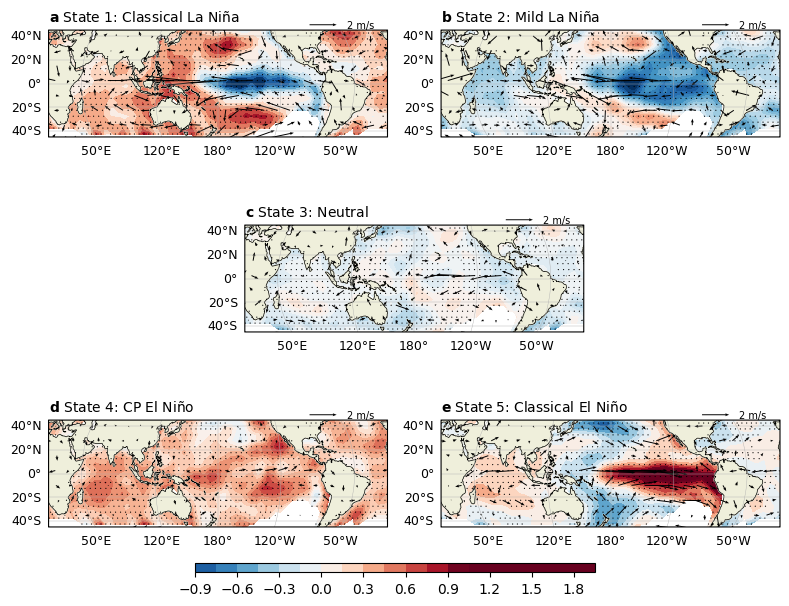

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.stats import ttest_ind_from_stats

def plot_global_ssta(ax, state, vmin, vmax, significance_map):
    
    ssta_data = np.load(f"SSTA_MEAN_STATE_{state}.npy")  
    uwind = np.load(f"UWNDA_MEAN_STATE_{state}.npy")
    vwind = np.load(f"VWNDA_MEAN_STATE_{state}.npy")
    
    
    lat = np.linspace(-87.5, 87.5, 36)
    lon = np.linspace(2.5, 357.5, 72)
    lon2d, lat2d = np.meshgrid(lon, lat)
    
    lat_wind = np.linspace(90, -90, uwind.shape[0])  
    lon_wind = np.linspace(0, 357.5, uwind.shape[1]) 
    #lon_wind_adjusted = np.where(lon_wind > 180, lon_wind - 360, lon_wind)
    lon_wind_adjusted = lon_wind
   
    lon2d_wind, lat2d_wind = np.meshgrid(lon_wind_adjusted, lat_wind)
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, linestyle=':')
    img = ax.contourf(lon, lat, ssta_data, transform=ccrs.PlateCarree(), cmap="RdBu_r", levels=20, vmin=vmin, vmax=vmax)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='face', facecolor=cfeature.COLORS['land'])
    
    sig_lat, sig_lon = lat2d[significance_map], lon2d[significance_map]
    ax.scatter(sig_lon, sig_lat, s=3, color='black', edgecolors='none', marker='.', transform=ccrs.PlateCarree())


   
    quiver_key_scale = 25 
    skip = (slice(None, None, 5), slice(None, None, 5)) 
    quiver = ax.quiver(lon2d_wind[skip], lat2d_wind[skip], uwind[skip], vwind[skip], transform=ccrs.PlateCarree(), 
              color='black', scale=quiver_key_scale, headwidth=3, headlength=4, headaxislength=3.5)
    
    qk = ax.quiverkey(quiver, X=0.85, Y=1.05, U=2, 
                  label='2 m/s',coordinates='axes',fontproperties={'size':7},labelpos='E')

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.3, xlocs=[ 50, 120, 180, -120, -50])
    gl.top_labels = False
    gl.right_labels = False
    
    gl.xlabel_style = {'size': 9, 'style': 'normal'}
    gl.ylabel_style = {'size': 9, 'style': 'normal'}
    
    ax.set_extent([-180, 180, -45, 45], crs=ccrs.PlateCarree())
    
    return img

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(3, 4, figure=fig)

# 添加子图
ax1 = fig.add_subplot(gs[0, :2], projection=ccrs.Robinson(central_longitude=180)) 
ax2 = fig.add_subplot(gs[0, 2:], projection=ccrs.Robinson(central_longitude=180))  
ax3 = fig.add_subplot(gs[1, 1:3], projection=ccrs.Robinson(central_longitude=180)) 
ax4 = fig.add_subplot(gs[2, :2], projection=ccrs.Robinson(central_longitude=180))  
ax5 = fig.add_subplot(gs[2, 2:], projection=ccrs.Robinson(central_longitude=180))  

axs_flat = [ax1, ax2, ax3, ax4, ax5]
titles = ["a State 1: Classical La Niña", "b State 2: Mild La Niña", "c State 3: Neutral", "d State 4: CP El Niño", "e State 5: Classical El Niño"]
significant_maps = significant_maps

for ax, state, title in zip(axs_flat, [2, 1, 3, 5, 4], titles):
    letter, rest_of_title = title.split(' ', 1)
    formatted_title = r'$\bf{' + letter + '}$ ' + rest_of_title
    
    img = plot_global_ssta(ax, state, -1.0, 1.0, significant_maps[state])
    ax.set_title(formatted_title, loc='left',size=10)
    

cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal", pad=0.05, shrink=0.5)
#cbar.set_label('Sea Surface Temperature Anomaly')

plt.tight_layout()
plt.savefig("combined_ssta5.tiff", format="tiff", dpi=500, bbox_inches='tight', pad_inches=0.05)

plt.show()
